In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl, matplotlib.pyplot as plt, matplotlib.colors as mplcolors
import numpy as np
from scipy import stats
from neurodyn import *

## Dynamics in $[0,1]$ using downsampling

Note : we compute $\tilde J_{\alpha\beta}$ using uniform sampling in CDF space

In [5]:
def plot_demo(mapping: BinMapping, rnn: LowRankRNN):
	res = rnn.simulate(h0=rnn.F[:, 0], t_span=(0, 50), dt_max=1, progress=True)
	is_downsampled = len(rnn.F) != mapping.num_bins

	fig, ax = plt.subplots(ncols=4, figsize=(12, 3), layout='constrained')
	ax[0].set_title(f'Kernel $w_{{\\alpha\\beta}}$ in embedding')
	ax[0].set_xlabel('embedding position $\\beta$')
	ax[0].set_ylabel('embedding position $\\alpha$')
	im = ax[0].matshow(rnn.params.to_dense().J, cmap='seismic', norm=mplcolors.TwoSlopeNorm(vcenter=0.0), extent=((0,1,0,1)))
	fig.colorbar(im, ax=ax[0])

	plot_overlap_trajectory(rnn, res, figax=(fig, ax[1]))

	ax[2].scatter(*rnn.F.T, c=rnn.phi(rnn.F[:, 0]), cmap='RdBu_r', vmin=0, vmax=1)
	ax[2].set_title(f'Neurons in state $\\xi_0$ (N={len(rnn.F)})')
	ax[2].set_xlabel('$\\xi_0$')
	ax[2].set_ylabel('$\\xi_1$')

	ax[3].scatter(*rnn.F.T, c=rnn.phi(rnn.F[:, 1]), cmap='RdBu_r', vmin=0, vmax=1)
	ax[3].set_title(f'Neurons in state $\\xi_1$ (N={len(rnn.F)})')
	ax[3].set_xlabel('$\\xi_0$')
	ax[3].set_ylabel('$\\xi_1$')

	fig.suptitle(f'{str(mapping)}, {is_downsampled=}')
	# plt.show()

### downsampled reshape

simulating LowRankCyclingRNN{N=4, p=2, delta=10, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=50.000 of 50 [00:00<00:00]
simulating LowRankCyclingRNN{N=16, p=2, delta=10, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=50.000 of 50 [00:00<00:00]
simulating LowRankCyclingRNN{N=4, p=2, delta=10, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=50.000 of 50 [00:00<00:00]
simulating LowRankCyclingRNN{N=256, p=2, delta=10, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=50.000 of 50 [00:00<00:00]
simulating LowRankCyclingRNN{N=16, p=2, delta=10, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=50.000 of 50 [00:00<00:00]


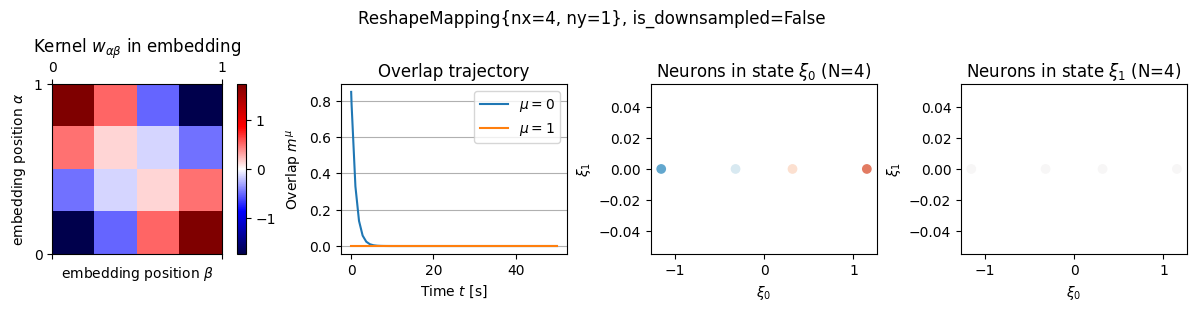

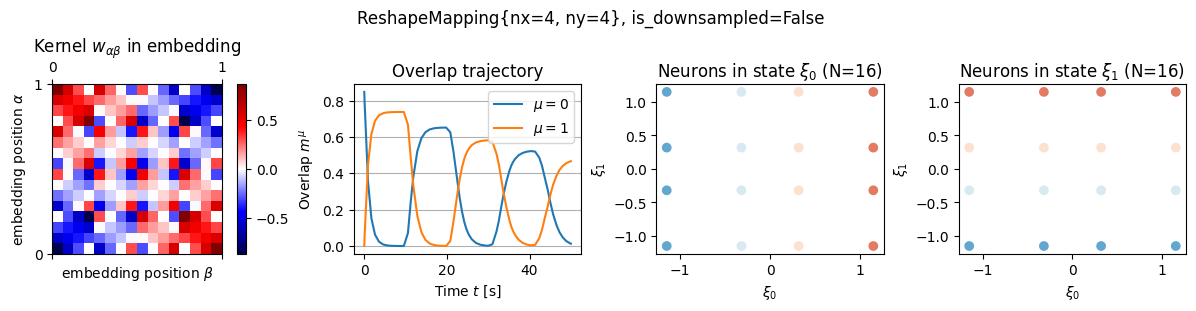

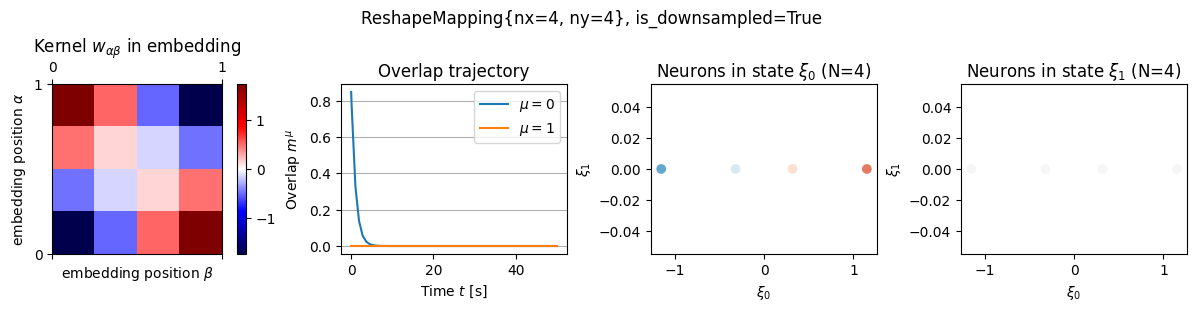

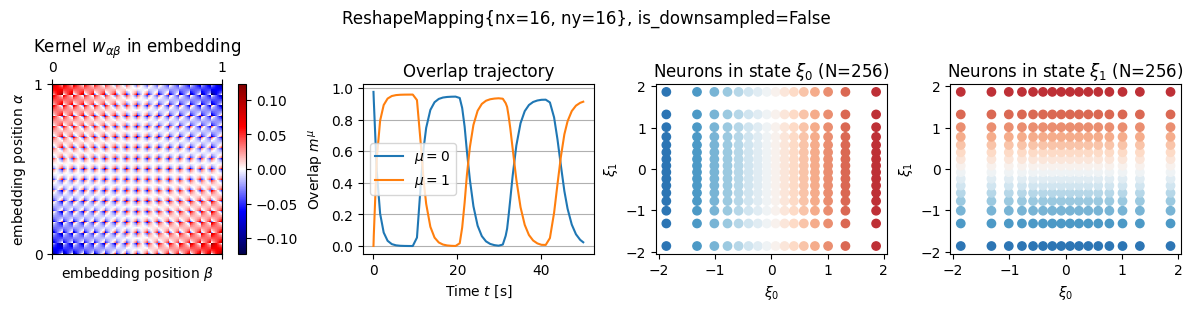

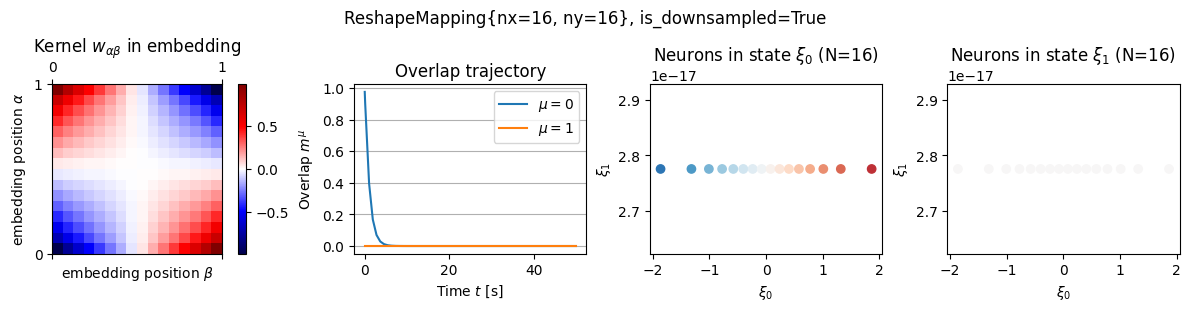

In [6]:
bbox = Box(xmin=-4, xmax=4, ymin=-4, ymax=4)

mapping = ReshapeMapping(nx=4**1, ny=1)
rnn = LowRankCyclingRNN.new_sampled_valentin(phi=sigmoid, mapping_samples=mapping.inverse_samples(), I_ext=zero, exclude_self_connections=False, delta=10, shift=1)
plot_demo(mapping, rnn)

mapping = ReshapeMapping(nx=2**2, ny=2**2)
rnn = LowRankCyclingRNN.new_sampled_valentin(phi=sigmoid, mapping_samples=mapping.inverse_samples(), I_ext=zero, exclude_self_connections=False, delta=10, shift=1)
plot_demo(mapping, rnn)
rnn = LowRankCyclingRNN(rnn.params.downsampled())
plot_demo(mapping, rnn)

mapping = ReshapeMapping(nx=2**4, ny=2**4)
rnn = LowRankCyclingRNN.new_sampled_valentin(phi=sigmoid, mapping_samples=mapping.inverse_samples(), I_ext=zero, exclude_self_connections=False, delta=10, shift=1)
plot_demo(mapping, rnn)
rnn = LowRankCyclingRNN(rnn.params.downsampled())
plot_demo(mapping, rnn)

#### intuition for the reshape mapping

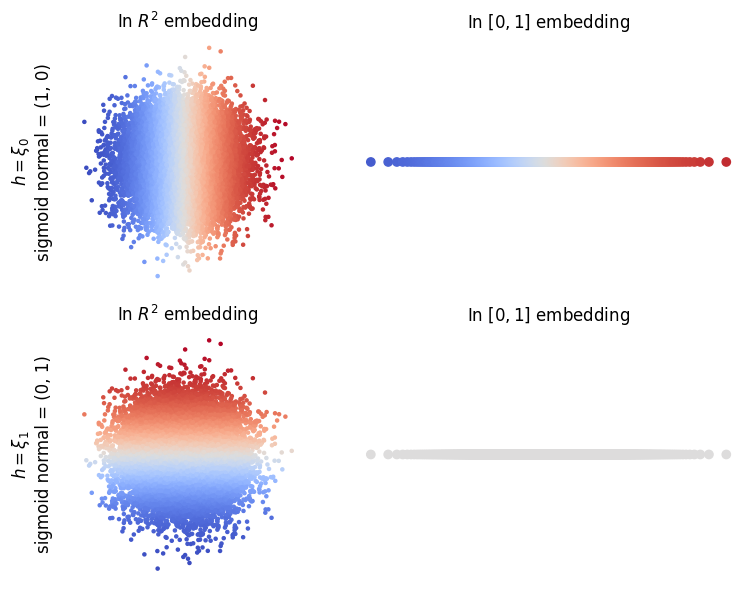

In [12]:
params = LowRankCyclingRNNParams.new_valentin(p=2, N=20_000, phi=sigmoid, I_ext=zero, exclude_self_connections=True, delta=6, shift=1)
F = params.F
normals = [(1,0), (0,1)]

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 6), layout='tight')

for ax, n in zip(axes, normals):
	F_avg = LowRankRNNParams.new_sampled_valentin(
		phi=sigmoid,
		mapping_samples=ReshapeMapping(nx=2**10, ny=2**10).inverse_samples(),
		I_ext=zero, exclude_self_connections=True
	).downsampled().F
	ax[1].scatter(*F_avg.T, c=fake_activity(F_avg, n), cmap='coolwarm', vmin=0, vmax=1)
	ax[1].axis('off')
	ax[1].set_title('In $[0,1]$ embedding')

	ax[0].scatter(*F.T, c=fake_activity(F, n), s=5, cmap='coolwarm')
	ax[0].set_aspect('equal')
	ax[0].axis('off')
	ax[0].set_title('In $R^2$ embedding')

add_headers(fig=fig, row_headers=[f'$h=\\xi_{i}$\nsigmoid normal = {n}' for i, n in enumerate(normals)], fontsize='large')

# fig.savefig('../presentation/2023-04-20/why_reshape_doesnt_work.png', transparent=True)
plt.show()

In [13]:
params = LowRankCyclingRNNParams.new_valentin(p=2, N=20_000, phi=sigmoid, I_ext=zero, exclude_self_connections=True, delta=6, shift=1)
F = params.F

ReshapeMapping{nx=4, ny=4}


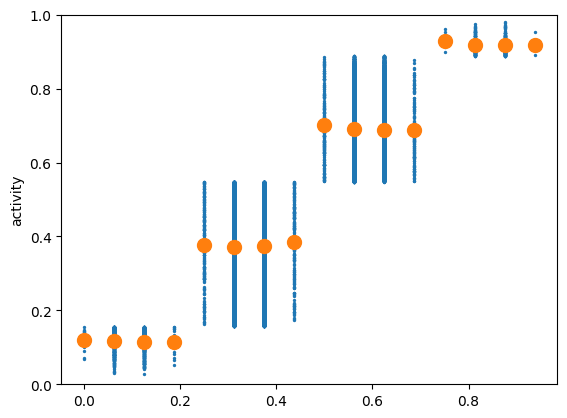

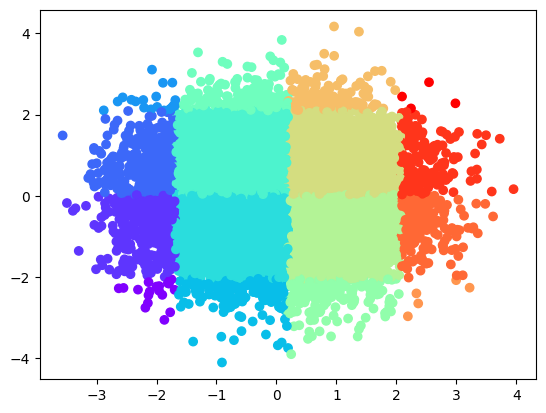

ReshapeMapping{nx=1, ny=16}


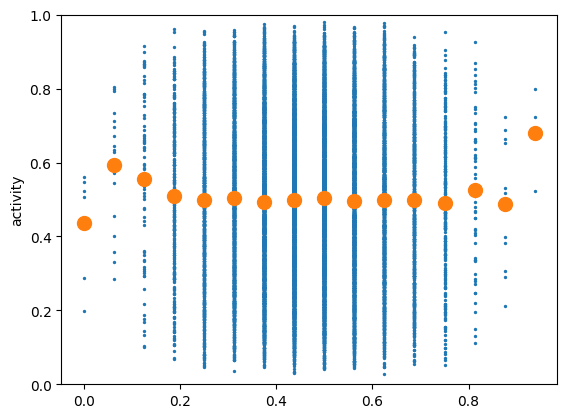

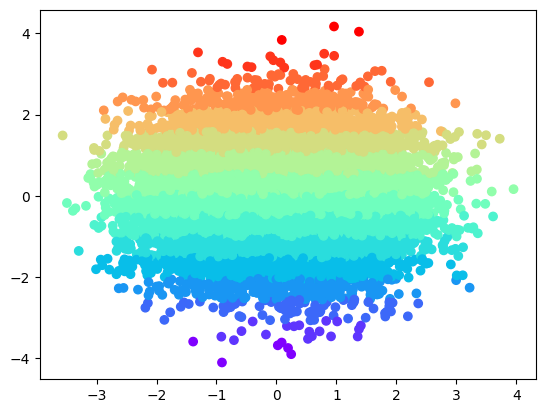

ReshapeMapping{nx=16, ny=1}


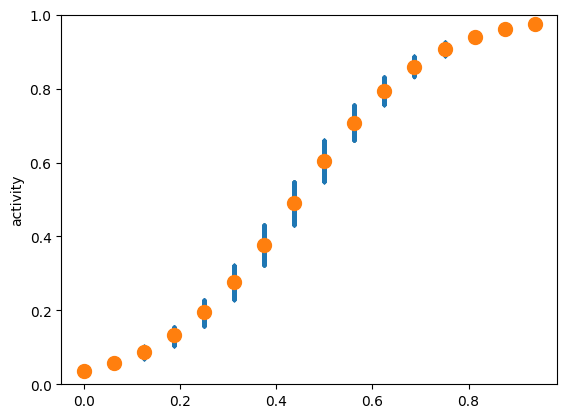

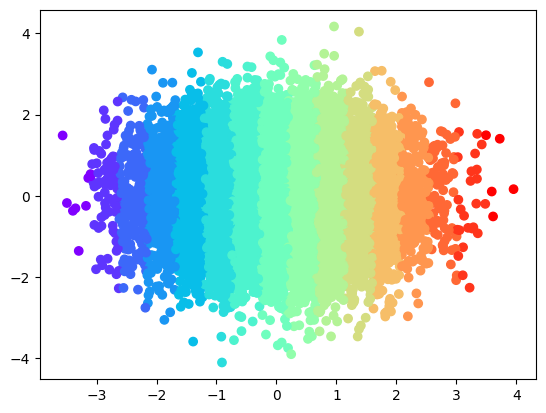

In [14]:
nrec = 2
n = (1,0)

for mapping in (ReshapeMapping(nx=2**nrec, ny=2**nrec), ReshapeMapping(nx=1, ny=4**nrec), ReshapeMapping(nx=4**nrec, ny=1)):
	print(mapping)
	values = mapping(F)
	plt.scatter(values, fake_activity(F, n), s=2)
	plt.scatter(np.linspace(0, 1-4**(-nrec), mapping.num_bins), mapping.binned_statistic(F, fake_activity(F, n), fill_na=None), s=100);
	plt.ylim((0,1))
	plt.ylabel('activity')
	plt.show()
	plt.scatter(*F.T, c=values, cmap='rainbow')
	plt.show()

1. has a gradient along x, so we get groups of 2^n bins with the same activity, but still some sigmoid, as if nx=2^n
2. has no graident along x. dynamics do not work ! -> basically projection to y axis (we are basically taking the marginal of the gaussian, integrating out the x component)
3. has only a graident along x (ny = 1). we see a nice sigmoid -> basically projection to x axis

when we average, the effect is the same as the projection along the y axis

### downsampled recursivelocal

simulating LowRankCyclingRNN{N=4, p=2, delta=10, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=50.000 of 50 [00:00<00:00]
simulating LowRankCyclingRNN{N=2, p=2, delta=10, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=50.000 of 50 [00:00<00:00]
simulating LowRankCyclingRNN{N=16, p=2, delta=10, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=50.000 of 50 [00:00<00:00]
simulating LowRankCyclingRNN{N=4, p=2, delta=10, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=50.000 of 50 [00:00<00:00]
simulating LowRankCyclingRNN{N=64, p=2, delta=10, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=50.000 of 50 [00:00<00:00]
simulating LowRankCyclingRNN{N=8, p=2, delta=10, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=50.000 of 50 [00:00<00:00]
simulati

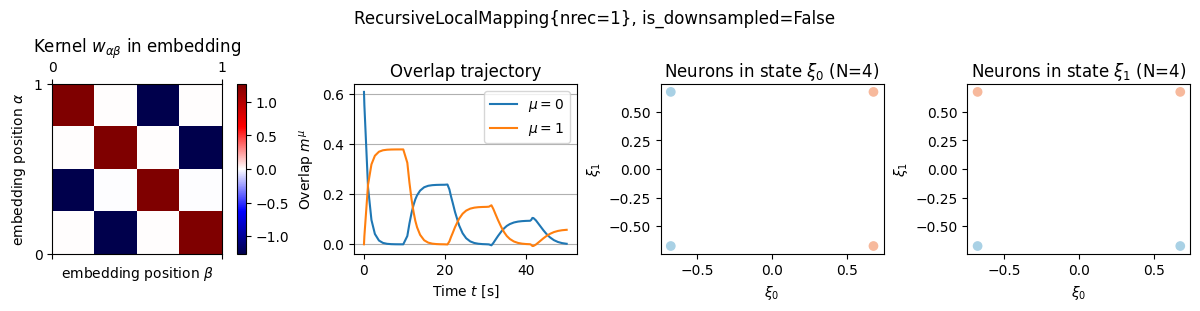

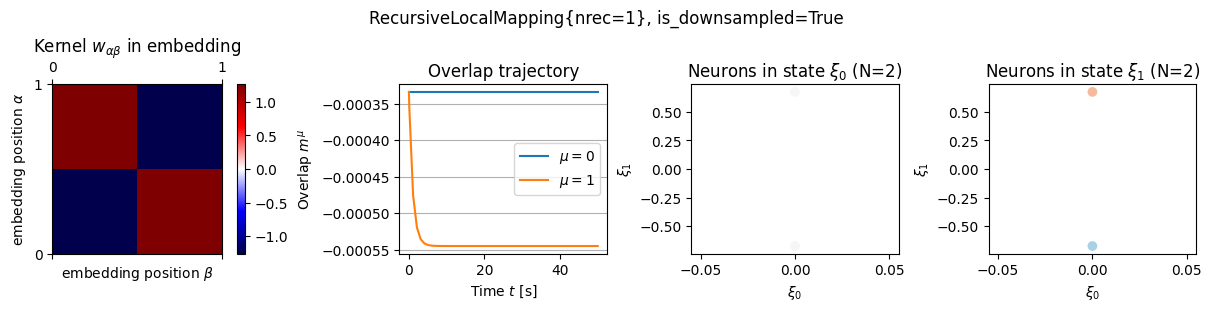

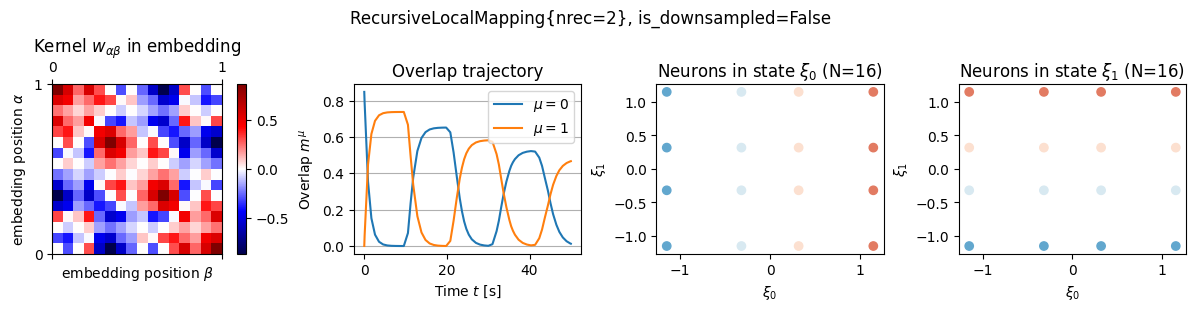

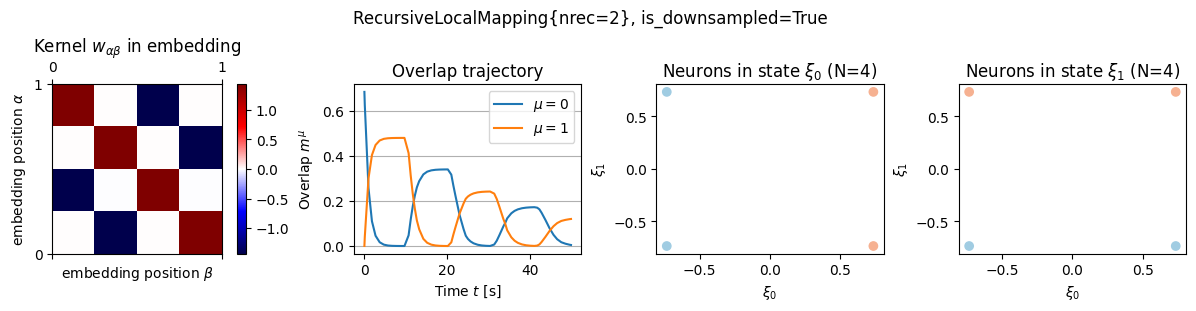

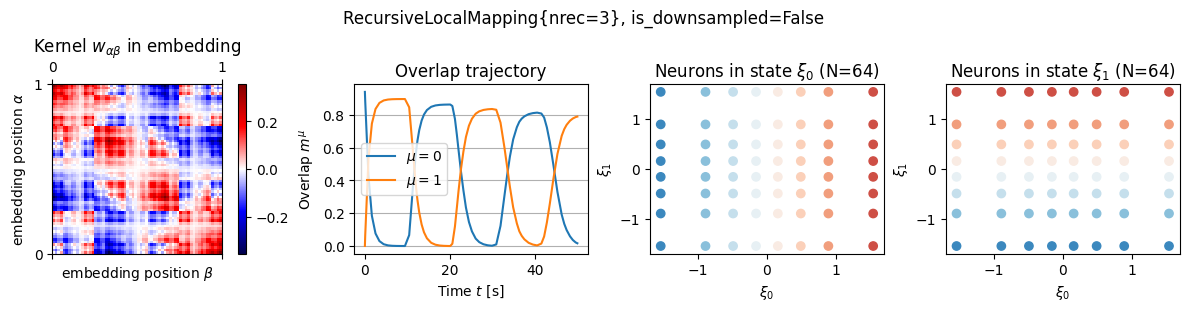

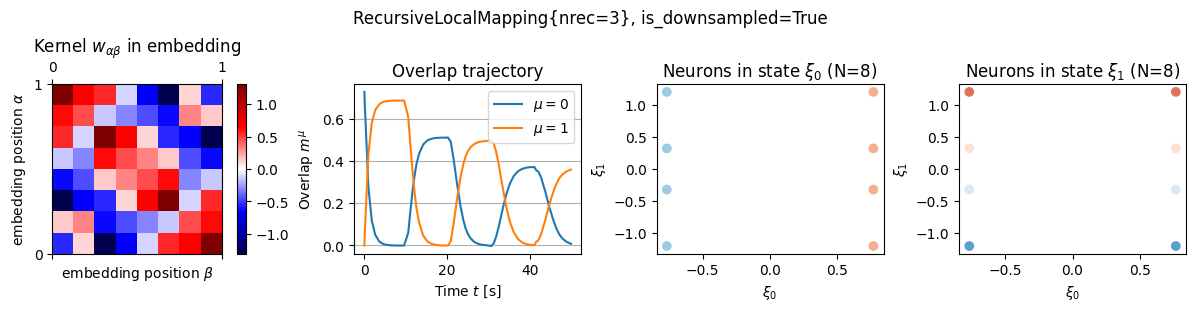

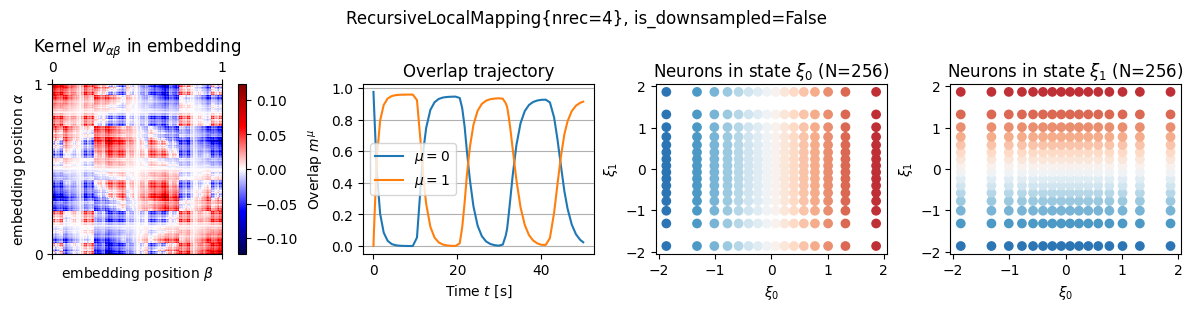

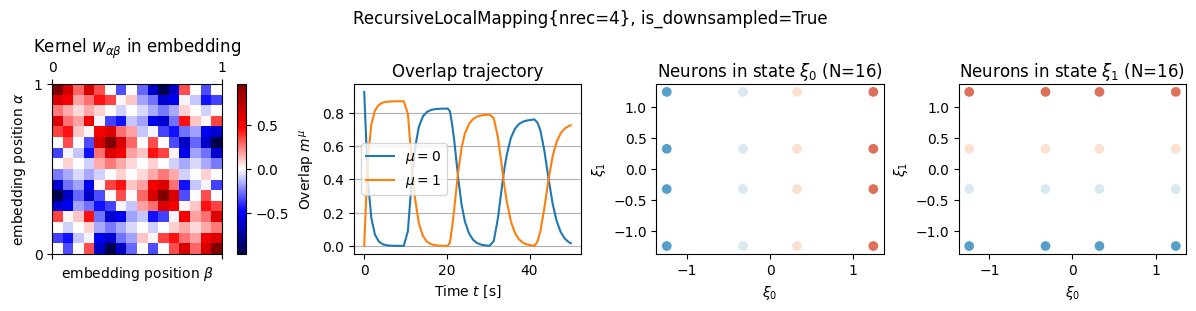

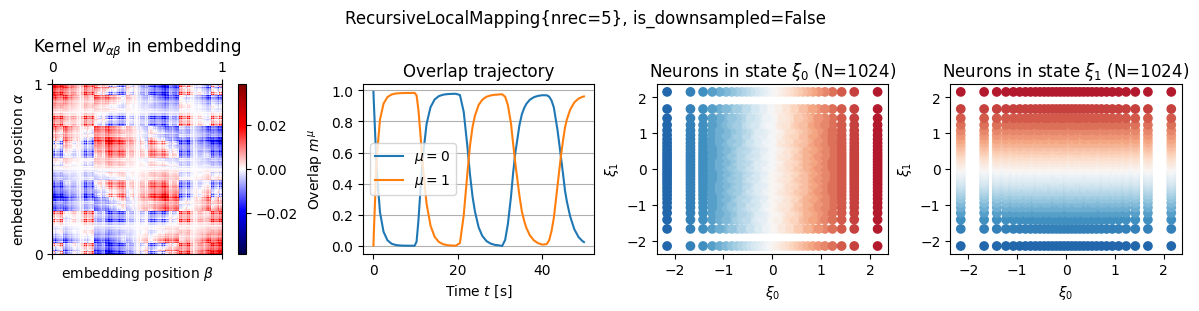

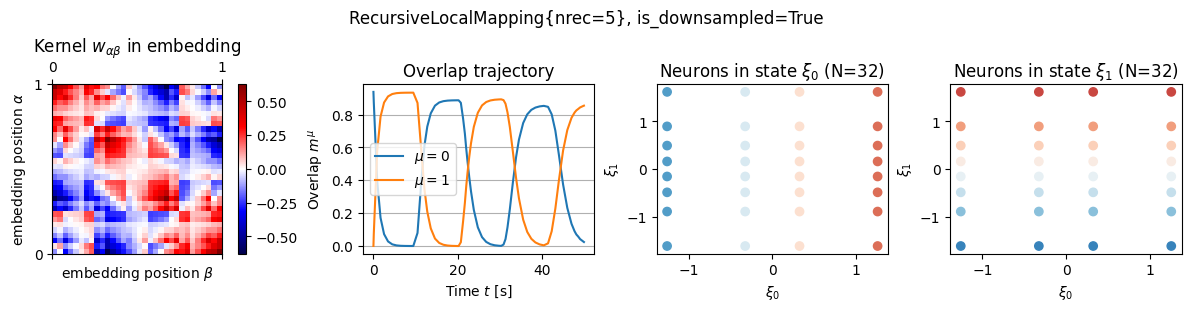

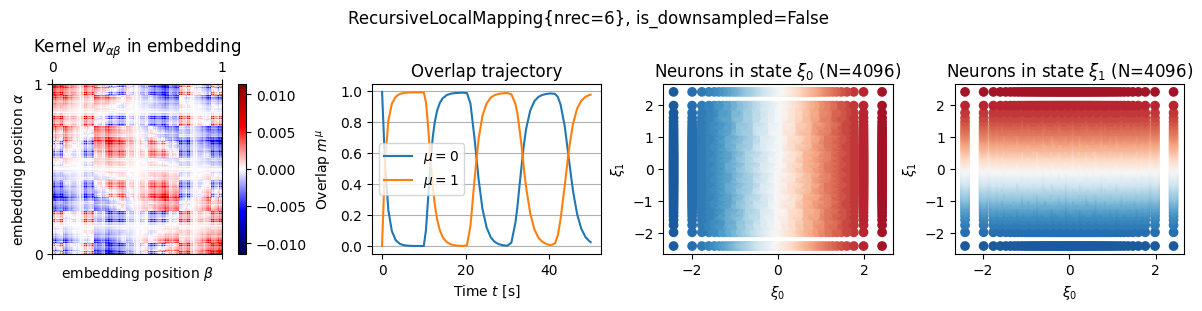

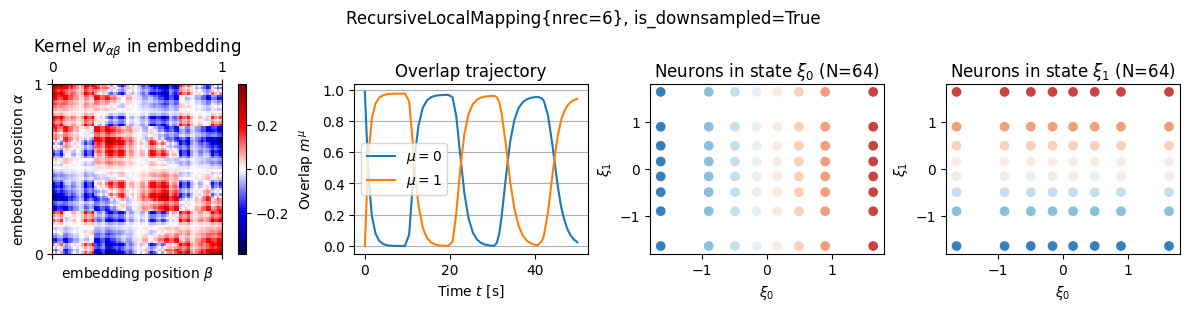

In [15]:
mapping = RecursiveLocalMapping(nrec=1)
rnn = LowRankCyclingRNN.new_sampled_valentin(phi=sigmoid, mapping_samples=mapping.inverse_samples(), I_ext=zero, exclude_self_connections=False, delta=10, shift=1)
plot_demo(mapping, rnn)
rnn = LowRankCyclingRNN(rnn.params.downsampled())
plot_demo(mapping, rnn)

mapping = RecursiveLocalMapping(nrec=2)
rnn = LowRankCyclingRNN.new_sampled_valentin(phi=sigmoid, mapping_samples=mapping.inverse_samples(), I_ext=zero, exclude_self_connections=False, delta=10, shift=1)
plot_demo(mapping, rnn)
rnn = LowRankCyclingRNN(rnn.params.downsampled())
plot_demo(mapping, rnn)

mapping = RecursiveLocalMapping(nrec=3)
rnn = LowRankCyclingRNN.new_sampled_valentin(phi=sigmoid, mapping_samples=mapping.inverse_samples(), I_ext=zero, exclude_self_connections=False, delta=10, shift=1)
plot_demo(mapping, rnn)
rnn = LowRankCyclingRNN(rnn.params.downsampled())
plot_demo(mapping, rnn)

mapping = RecursiveLocalMapping(nrec=4)
rnn = LowRankCyclingRNN.new_sampled_valentin(phi=sigmoid, mapping_samples=mapping.inverse_samples(), I_ext=zero, exclude_self_connections=False, delta=10, shift=1)
plot_demo(mapping, rnn)
rnn = LowRankCyclingRNN(rnn.params.downsampled())
plot_demo(mapping, rnn)

mapping = RecursiveLocalMapping(nrec=5)
rnn = LowRankCyclingRNN.new_sampled_valentin(phi=sigmoid, mapping_samples=mapping.inverse_samples(), I_ext=zero, exclude_self_connections=False, delta=10, shift=1)
plot_demo(mapping, rnn)
rnn = LowRankCyclingRNN(rnn.params.downsampled())
plot_demo(mapping, rnn)

mapping = RecursiveLocalMapping(nrec=6)
rnn = LowRankCyclingRNN.new_sampled_valentin(phi=sigmoid, mapping_samples=mapping.inverse_samples(), I_ext=zero, exclude_self_connections=False, delta=10, shift=1)
plot_demo(mapping, rnn)
rnn = LowRankCyclingRNN(rnn.params.downsampled())
plot_demo(mapping, rnn)

### Summary plot, compare with 2D embedding

are the dynamics the same in [0,1] and in Rp ?

we generate a "high-def" mapping, then downsample to the same number of neurons for every mapping and the ground truth

In [17]:
nrec_compare = 6  # 4**nrec_compare is the number of neurons
nrec_fractal = 2*nrec_compare
# TODO : there has to be a way to average which doesn't involve 2*nrec
# my computer cannot go beyond nrec=10 for recursive quadrant
bbox = Box(xmin=-4, xmax=4, ymin=-4, ymax=4)

rnn_gt = LowRankCyclingRNN.new_valentin(p=2, N=4**nrec_compare, phi=sigmoid, I_ext=zero, exclude_self_connections=False, delta=10, shift=1)
res_gt = rnn_gt.simulate(h0=rnn_gt.F[:, 0], t_span=(0, 50), dt_max=1)
print(rnn_gt)

rnn_reclocal = LowRankCyclingRNN(LowRankCyclingRNNParams.new_sampled_valentin(
	phi=sigmoid,
	mapping_samples=RecursiveLocalMapping.new_nrec(nrec_fractal).inverse_samples(),
	I_ext=zero, exclude_self_connections=False, delta=10, shift=1
).downsampled())
res_reclocal = rnn_reclocal.simulate(h0=rnn_reclocal.F[:, 0], t_span=(0, 50), dt_max=1)
print(rnn_reclocal)

rnn_reshape = LowRankCyclingRNN(LowRankCyclingRNNParams.new_sampled_valentin(
	phi=sigmoid,
	mapping_samples=ReshapeMapping.new_nrec(nrec_fractal).inverse_samples(),
	I_ext=zero, exclude_self_connections=False, delta=10, shift=1
).downsampled())
res_reshape = rnn_reshape.simulate(h0=rnn_reshape.F[:, 0], t_span=(0, 50), dt_max=1)
print(rnn_reshape)

LowRankCyclingRNN{N=4096, p=2, delta=10, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}
LowRankCyclingRNN{N=4096, p=2, delta=10, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}
LowRankCyclingRNN{N=4096, p=2, delta=10, shift=1, phi=sigmoid, I_ext=zero, exclude_self_connections=False}


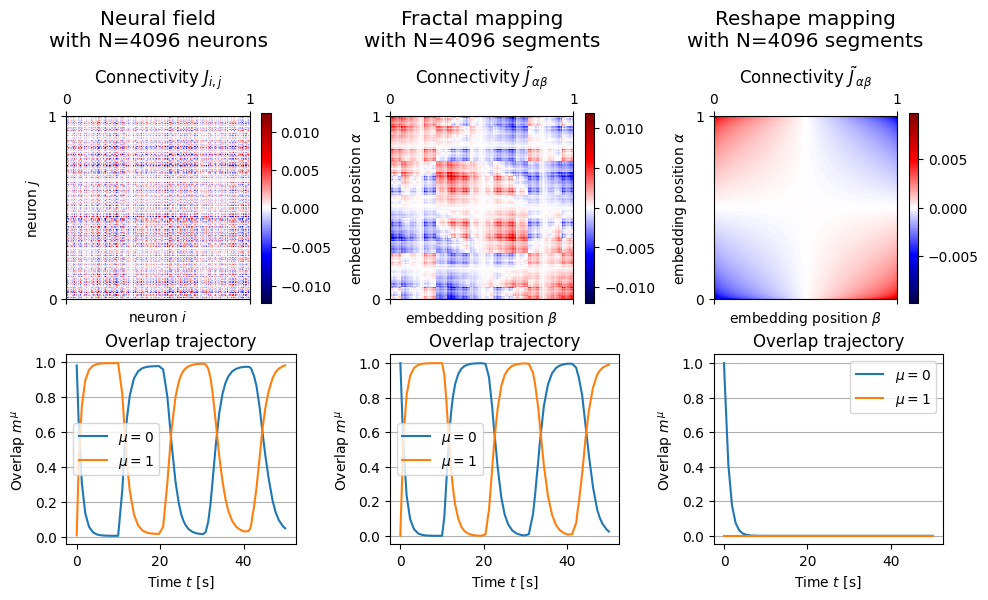

In [18]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(10, 6), layout='tight')

axes[0, 0].set_title(f'Connectivity $J_{{i,j}}$')
axes[0, 0].set_xlabel('neuron $i$')
axes[0, 0].set_ylabel('neuron $j$')
im = axes[0, 0].matshow(rnn_gt.params.to_dense().J, cmap='seismic', norm=mplcolors.TwoSlopeNorm(vcenter=0.0), extent=((0,1,0,1)))
fig.colorbar(im, ax=axes[0, 0])

axes[0, 1].set_title(f'Connectivity $\\tilde J_{{\\alpha\\beta}}$')
axes[0, 1].set_xlabel('embedding position $\\beta$')
axes[0, 1].set_ylabel('embedding position $\\alpha$')
im = axes[0, 1].matshow(rnn_reclocal.params.to_dense().J, cmap='seismic', norm=mplcolors.TwoSlopeNorm(vcenter=0.0), extent=((0,1,0,1)))
fig.colorbar(im, ax=axes[0, 1])

axes[0, 2].set_title(f'Connectivity $\\tilde J_{{\\alpha\\beta}}$')
axes[0, 2].set_xlabel('embedding position $\\beta$')
axes[0, 2].set_ylabel('embedding position $\\alpha$')
im = axes[0, 2].matshow(rnn_reshape.params.to_dense().J, cmap='seismic', norm=mplcolors.TwoSlopeNorm(vcenter=0.0), extent=((0,1,0,1)))
fig.colorbar(im, ax=axes[0, 2])

plot_overlap_trajectory(rnn_gt, res_gt, figax=(fig, axes[1, 0]))
plot_overlap_trajectory(rnn_reclocal, res_reclocal, figax=(fig, axes[1, 1]))
plot_overlap_trajectory(rnn_reshape, res_reshape, figax=(fig, axes[1, 2]))

add_headers(
	axes=axes.flat,
	col_headers=[f'Neural field\nwith N={4**nrec_compare} neurons', f'Fractal mapping\nwith N={4**nrec_compare} segments', f'Reshape mapping\nwith N={4**nrec_compare} segments'],
	col_pad=50, fontsize='x-large'
)

# fig.savefig('../presentation/2023-04-20/dynamics_compare.png', transparent=True)
plt.show()

## Simulations using implemented code

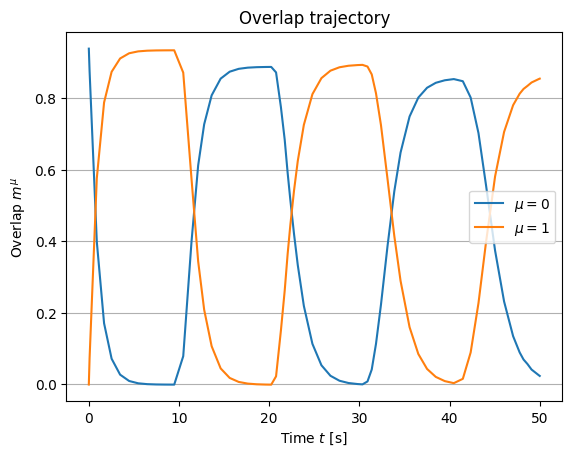

In [19]:
rnn = LowRankCyclingRNN(LowRankCyclingRNNParams.new_sampled_valentin(
	phi=sigmoid,
	mapping_samples=RecursiveLocalMapping.new_nrec(5).inverse_samples(),
	I_ext=zero, exclude_self_connections=False, delta=10, shift=1
).downsampled())
res = rnn.simulate(h0=rnn.F[:, 0], t_span=(0, 50), dt_max=1)
plot_overlap_trajectory(rnn, res);

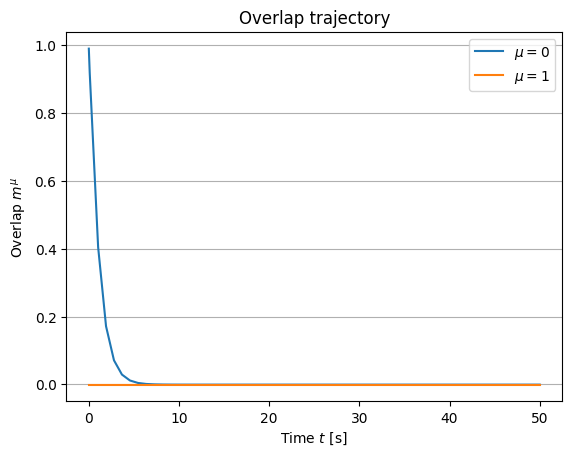

In [20]:
rnn = LowRankCyclingRNN(LowRankCyclingRNNParams.new_sampled_valentin(
	phi=sigmoid,
	mapping_samples=ReshapeMapping.new_nrec(5).inverse_samples(),
	I_ext=zero, exclude_self_connections=False, delta=10, shift=1
).downsampled())
res = rnn.simulate(h0=rnn.F[:, 0], t_span=(0, 50), dt_max=1)
plot_overlap_trajectory(rnn, res);

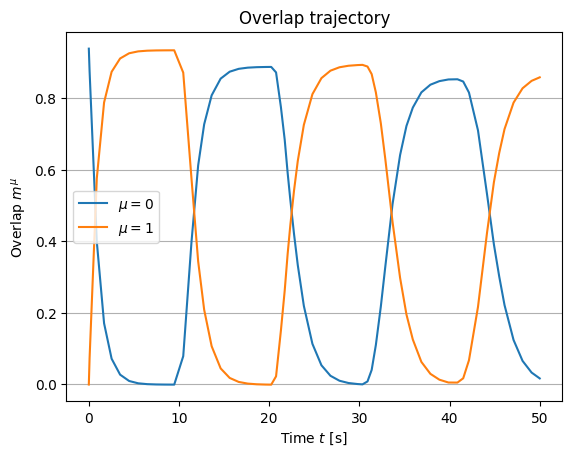

In [21]:
rnn = LowRankCyclingRNN(LowRankCyclingRNNParams.new_sampled_valentin(
	phi=sigmoid,
	mapping_samples=ZMapping.new_nrec(5).inverse_samples(),
	I_ext=zero, exclude_self_connections=False, delta=10, shift=1
).downsampled())
res = rnn.simulate(h0=rnn.F[:, 0], t_span=(0, 50), dt_max=1)
plot_overlap_trajectory(rnn, res);